# Costa Rican Household Poverty Level Prediction

참고 : https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough

이 대회는 개인과 가구를 활용해 가구의 빈곤 수준을 예측하는 기계학습 모델을 개발하는 것이 목표다.

우선, 문제에 대해 소개를 하고, 데이터셋에 대해 EDA(Exploratory Data Analysis)를 수행하고, feature engineering을 하고, 다중 기계학습 모델을 시도해보고, 모델을 선택하고, 모델을 최적화하고, 마지막으로 모델의 결과를 검토하고 결론을 짓는다.

## Problem and Data Explanation

데이터는 train.csv와 test.csv가 주어진다. train 셋은 9557개 행 143개 열로, test 셋은 23856개 행, 142개 열로 이뤄진다. 각 행은 각 개인을 나타내고, 각 열은 개인당 가구 혹은 개인의 고유한 변수를 나타낸다. train 셋은 빈곤수준이 1-4 크기인 추가적인 target 열이 있다. 1값은 가장 심한 빈곤상태다.

다중 분류 기계학습 문제
- Supervised : train 데이터의 레이블과 함께 제공
- Multi-class classification : 레이블이 4가지인 이산형 값

### Objective

가정의 빈곤을 예측하는 것이 목표다. 고유한 변수를 갖는 각 개인에 대한 데이터와 그들의 가구에 대한 정보가 주어진다. 작업할 데이터셋을 생성하기 위해, 각 가구에 대한 개별 데이터의 집계를 해야한다. test 셋의 모든 개인에 대해 예측해야 하지만, "가구의 가장만 점수에 사용된다". 즉, 가구 단위로 빈곤을 예측할 것이다.

참고 : train 데이터에서 모든 가족 구성원은 동일한 레이블을 가져야하지만, 같은 가구의 개인들이 다른 레이블을 갖는다는 오류가 있다. 이 경우, 각 가정의 가장에 대한 레이블을 사용하는데, parentesco1==1.0인 행으로 식별할 수 있다. 

target값은 다음과 같은 빈곤 수준을 나타낸다.
- 1 : 아주 빈곤
- 2 : 보통 빈곤
- 3 : 취약 계층
- 4 : 취약 계층이 아님

143개 열 중 주의할 것
- id : 각 개인의 고유 식별자. 사용하지 않는 변수다.
- idhogar : 각 가정에 대한 고유 식별자. 변수는 아니지만, 가구의 모든 개인이 동일한 식별자를 가지므로 가구별 개인을 그룹화하는 데 사용한다.
- parentesco1 : 가정의 가장 여부
- target : 가정의 모든 구성원에 대해 동일해야하는 레이블

모델을 만들 때, 가구별 '가장의 빈곤 수준'을 레이블로 가정을 학습시킨다. 원데이터는 가구와 개인이 섞여있으며, 개인 데이터는 각 가구당 집계할 수 있는 방법을 찾아야한다. 일부 개인은 가장이 없는 가정에 속해있어 이 데이터를 학습시킬 수 없다. 이런 데이터 문제는 현실적인 데이터의 아주 전형적인 문제이므로 데이터사이언스 작업에서 마주치는 데이터셋에 대한 준비가 필요하다.

### Metric

궁극적으로 가정의 빈곤 수준을 예측할 수 있는 기계학습 모델을 구축해야한다. 예측 성능은 Macro F1 Score로 평가될 것이다. precision과 recall의 조화 평균인 이항 분류 문제에 대해 표준 F1 score를 사용한다.

다중 클래스 문제는 각 클래스에 F1 score 평균을 낸다. macro F1 score는 레이블 불균형을 고려하지 않고 각 클래스의 F1 score를 평균 낸다. 즉, macro를 사용할 때('가중화된' 점수를 사용할 때) 각 레이블의 발생 횟수는 계산에 포함되지 않는다. 

## Roadmap

최종 목표는 가정의 빈곤 수준을 예측하는 기계학습 모델이다. 우선 문제와 데이터를 이해해야한다. 한 모델을 '최고'라고 선택하기 전, 수많은 모델을 평가하고, 모델을 만든 후 예측을 검토해야한다. 

로드맵
1. 문제 이해
2. EDA (Exploratory Data Analysis)
3. 기계학습을 위한 데이터셋 생성을 위한 Feature engineering
4. 기본 기계학습 모델 몇 가지 비교
5. 더 복잡한 기계학습 모델 사용
6. 선택한 모델 최적화
7. 모델 예측 검토
8. 결론 도출 및 다음 단계 제시

# Getting Started

문제에 대해 잘 알아봤으므로 EDA와 feature engineering으로 넘어간다. EDA는 feature engineering과 모델링에 사용되는 이상치, 추세, 상관관계, 패턴을 탐색한다. 데이터를 (통계량을 통해) 정량적으로 그리고 (그래프를 통해) 시각적으로 조사한다.

일단 데이터의 잠재적으로 유용한 관계를 파악하면, 일부 feature engineering (기계학습 파이프라인의 가장 중요한 부분)을 하고 기본 모델을 구축할 수 있다. 

시작해보자.

#### Imports

In [41]:
# 데이터 조작
import pandas as pd
import numpy as np
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
# plotting 기본값 설정
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

### Read in Data and Look at Summary Information

In [42]:
pd.options.display.max_columns = 150  ### 표 출력시 최대 열 수

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


130개 integer 열, 8개 float(numeric) 열, 5개 object 열이 있다는 것을 알 수 있다. integer열은 (0 또는 1을 갖는) Boolean 변수 혹은 이산형 순서값을 갖는 순서형 변수를 나타낸다. object 열은 기계학습 모델에 직접 입력할 수 없어 문제가 발생한다.

train보다 행이 많은 test 데이터를 살펴보자. target이 없어 열이 하나 적다.

In [44]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


#### Integer Columns

integer 열의 고유값 분포를 살펴보자. 각 열에 대해 고유한 값의 수를 세 결과를 bar plot에 표시한다.

Text(0.5, 1.0, 'Count of Unique Values in Integer Columns')

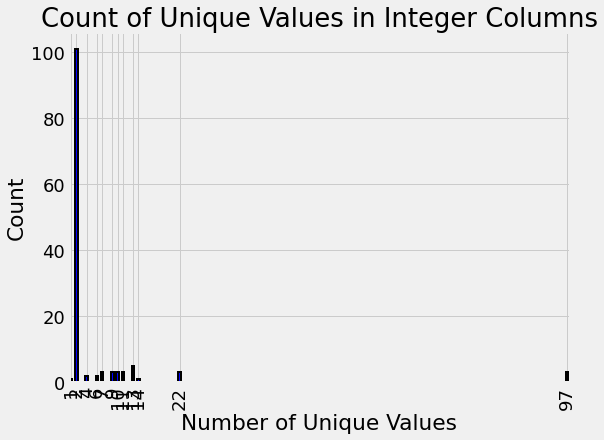

In [51]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='blue', figsize=(8,6), edgecolor='k', linewidth=2)
plt.xlabel('Number of Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in Integer Columns')

고유값이 2개만 있는 열은 Booleans(0 또는 1)을 나타낸다. 이 boolean 정보는 이미 가구 수준에 있다. 예를 들어, refrig 열은 가정에 냉장고가 있는지 여부다. 가구 수준이 나타나는 Boolean에서 변수를 만들 때 이것들을 집계할 필요가 없다. 하지만 개인 수준이 나타나는 Boolean열은 집계해야한다.